# Feature Engineering
This notebook adapts heavily from [Kushal Agrawal's](https://www.kaggle.com/kushal1506/moa-prediction-complete-walkthrough-eda-ensemble/notebook) Kaggle Notebook for *the* competition. 

## Adversarial Validation

One step in the feature engineering involves this method called [adversarial validation](https://towardsdatascience.com/adversarial-validation-ca69303543cd). Quoting from the original page, 

<center> "In short, we build a classifier to try to predict which data rows are from the training set, and which are from the test set. If the two datasets came from the same distribution, this should be impossible. But if there are systematic differences in the feature values of your training and test datasets, then a classifier will be able to successfully learn to distinguish between them. The better a model you can learn to distinguish them, the bigger the problem you have." </center>

In our case, *Categorical* features such as `cp_type`, `cp_time` and `cp_dose` are omitted in adversarial validation. Basically, we are going to replace our targets for both datasets (0 for training and 1 for test), then we're going to build a classifier which tries to predict which observation belongs to train set and which one belongs to test set. If datasets were randomly selected from similar distribution it should be really hard for the classifier to separate them. Yet, if there are sytematic selection differences between train and test sets then classifier should be able to capture this trend. So, we would like to see our models having lower score for the next section (0.50 in AUC) because higher detection rate means higher difference between train and test sets.



In [ ]:
!pip install iterative-stratification

In [ ]:
import os
import copy
from copy import deepcopy as dp
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from pickle import load,dump

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


In [ ]:
! unzip lish-moa.zip
! mkdir data
! mv *csv data/

train_features_df = pd.read_csv('data/train_features.csv')
test_features_df = pd.read_csv('data/test_features.csv')
train_targets_scored_df = pd.read_csv('data/train_targets_scored.csv')
train_targets_nonscored_df = pd.read_csv('data/train_targets_nonscored.csv')
train_drug_df = pd.read_csv('data/train_drug.csv')
sub = pd.read_csv('data/sample_submission.csv')

train_features_df['target'] = 0
test_features_df['target'] = 1

genes = [gene for gene in train_features_df.columns if gene.startswith('g-')]
cells = [cell for cell in train_features_df.columns if cell.startswith('c-')]

train_features2 = train_features_df.copy()
test_features2 = test_features_df.copy()

X = pd.concat([train_features_df.loc[:, genes + cells], 
               test_features_df.loc[:, genes + cells]]).reset_index(drop=True)
y = pd.concat([train_features_df.loc[:, 'target'], test_features_df.loc[:, 'target']]).reset_index(drop=True)




Archive:  lish-moa.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train_drug.csv          
  inflating: train_features.csv      
  inflating: train_targets_nonscored.csv  
  inflating: train_targets_scored.csv  


Running LightGBM Adversarial Validation Model
---------------------------------------------

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.946708	valid_1's auc: 0.517713
Early stopping, best iteration is:
[49]	training's auc: 0.945269	valid_1's auc: 0.520314

Fold 1 - ROC AUC Score 0.520314

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.954001	valid_1's auc: 0.518705
[100]	training's auc: 0.993757	valid_1's auc: 0.522393
Early stopping, best iteration is:
[91]	training's auc: 0.990851	valid_1's auc: 0.526378

Fold 2 - ROC AUC Score 0.526378

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.945997	valid_1's auc: 0.512796
[100]	training's auc: 0.990871	valid_1's auc: 0.518581
[150]	training's auc: 0.998747	valid_1's auc: 0.519554
Early stopping, best iteration is:
[130]	training's auc: 0.996971	valid_1's auc: 0.526325

Fold 3 - ROC AUC Score 0.526325

Training until validatio

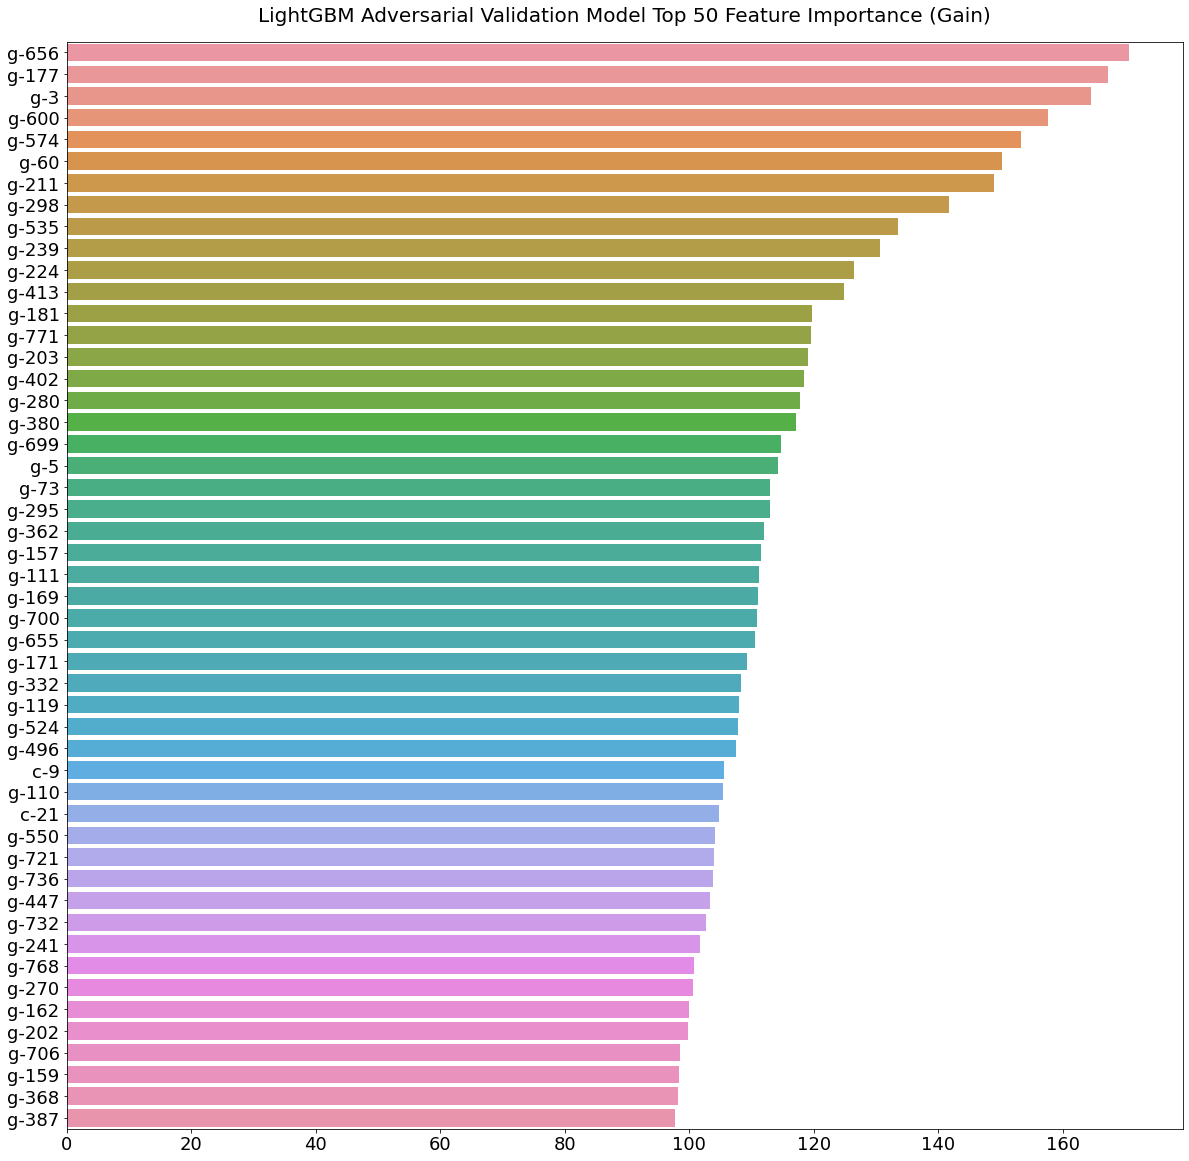

In [ ]:
k = 5

skf = StratifiedKFold(n_splits=k, random_state=721991, shuffle=True)
scores = []
oof_predictions = pd.DataFrame(np.zeros((X.shape[0], 1)), columns=['target'])
feature_importance = pd.DataFrame(np.zeros((X.shape[1], k)), 
                                  columns=[f'Fold_{i}_Importance' for i in range(1, k+1)], 
                                  index=X.columns)
parameters = {'num_iterations': 500,
    'early_stopping_round': 50,
    'num_leaves': 2 ** 5, 
    'learning_rate': 0.05,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'feature_fraction_bynode': 0.9,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'max_depth': -1,
    'objective': 'binary',
    'seed': 721991,
    'feature_fraction_seed': 721991,
    'bagging_seed': 721991,
    'drop_seed': 721991,
    'data_random_seed': 721991,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'auc',
    'n_jobs': -1,
    }

print('Running LightGBM Adversarial Validation Model\n' + ('-' * 45) + '\n')
for fold,(train_idx,val_idx) in enumerate(skf.split(X, y), 1):
    train_data = lgb.Dataset(X.iloc[train_idx,:], label=y.iloc[train_idx])
    val_data = lgb.Dataset(X.iloc[val_idx,:], label=y.iloc[val_idx])
    model = lgb.train(parameters, train_data, valid_sets=[train_data, val_data], verbose_eval=50)
    feature_importance.iloc[:,fold-1] = model.feature_importance(importance_type='gain')
    predictions = model.predict(X.iloc[val_idx, :], num_iteration=model.best_iteration)
    oof_predictions.loc[val_idx, 'target'] = predictions
    score=roc_auc_score(y.iloc[val_idx], predictions)
    scores.append(score)
    print(f'\nFold {fold} - ROC AUC Score {score:.6}\n')

oof_score = roc_auc_score(y, oof_predictions)
print(f'\n{"-" * 30}\nLightGBM Adversarial Validation Model Mean ROC AUC Score {np.mean(scores):.6} [STD:{np.std(scores):.6}]')
print(f'LightGBM Adversarial Validation Model OOF ROC AUC Score: {oof_score:.6}\n{"-" * 30}')

plt.figure(figsize=(20, 20))
feature_importance['Mean_Importance'] = feature_importance.sum(axis=1) / k
feature_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=feature_importance.index[:50], data=feature_importance[:50])
plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('LightGBM Adversarial Validation Model Top 50 Feature Importance (Gain)', size=20, pad=20)

plt.show()

del X, y, oof_predictions, feature_importance, parameters, scores, oof_score

Adversarial validation model yields ~ 0.525 ROC-AUC score which suggests that training and public test set are similar. Features at the top of feature importance plot have higher gain, because they have different means in training and public test set due to distribution tail extremeties. This could be related to small sample size of public test set, and this doesn't necessarily happen to private test set.

## Feature Scaling

From previous visualization, we observe that continuous features have different ranges of values. Feature scaling is useful to tackle this issue and improve speed too. Generally, `Quantile Transformer` has been used for genomics data which has also shown its effectiveness in this competition. For a given feature, this transformation will spread out the most frequent values. Furthermore, it also reduces the adverse impact of (marginal) outliers. Other scaling methods such as zero-centered data transformation tend to perform better for PCA, whereas min-max scaling method may perform better in neural networks. 

Min-max scaling and standard scaling are heavily influenced by outliers, while Gaussian-rank scaling yields more robust results. Gaussian-rank scaled data have symmetrical tails unlike others scaled data. 

### Train data before transformation

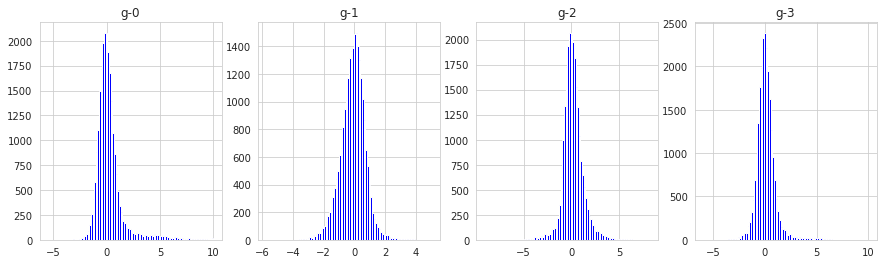

In [ ]:
plt.figure(figsize=(15, 4))
sns.set_style('whitegrid')
gene_choice = range(0, 4)
for i, col in enumerate(gene_choice):
    plt.subplot(1, 4, i+1)
    plt.hist(train_features_df.loc[:, genes[col]], bins=100, color="blue")
    plt.title(genes[col])

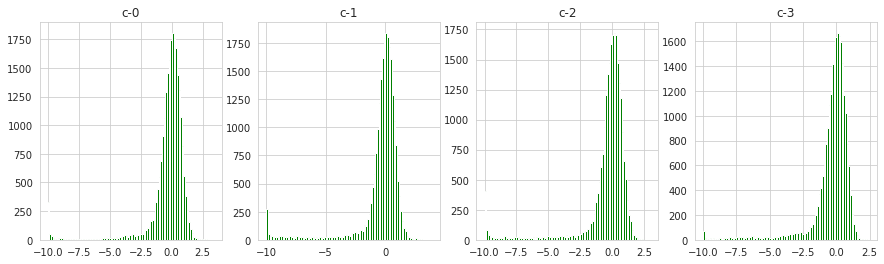

In [ ]:
plt.figure(figsize=(15, 4))
sns.set_style('whitegrid')
cell_choice= range(0, 4)
for i, col in enumerate(cell_choice):
    plt.subplot(1, 4, i+1)
    plt.hist(train_features_df.loc[:, cells[col]], bins=100, color="green")
    plt.title(cells[col])

In [ ]:
# qt = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
# train_features_df[genes + cells] = qt.fit_transform(train_features_df[genes + cells])
# test_features_df[genes + cells] = qt.transform(test_features_df[genes + cells])

for col in (genes + cells):

    transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution="normal")
    vec_len = len(train_features_df[col].values)
    vec_len_test = len(test_features_df[col].values)
    raw_vec = train_features_df[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features_df[col] = transformer.transform(test_features_df[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

### After Quantile Transformation

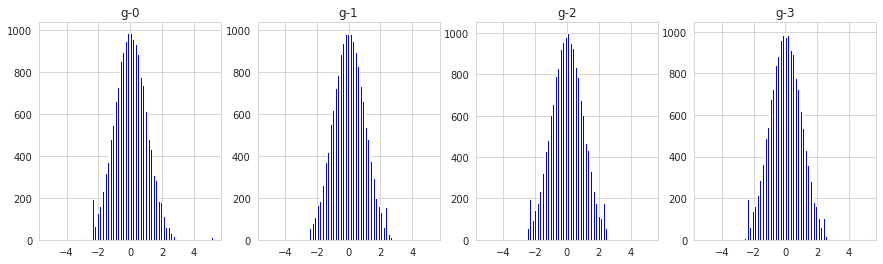

In [ ]:
plt.figure(figsize=(15, 4))
sns.set_style('whitegrid')
gene_choice = range(0, 4)
for i, col in enumerate(gene_choice):
    plt.subplot(1, 4, i+1)
    plt.hist(train_features_df.loc[:, genes[col]], bins=100, color="blue")
    plt.title(genes[col])

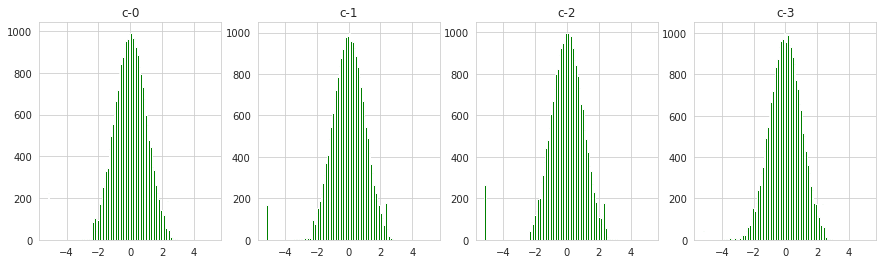

In [ ]:
plt.figure(figsize=(15, 4))
sns.set_style('whitegrid')
cell_choice= range(0, 4)
for i, col in enumerate(cell_choice):
    plt.subplot(1, 4, i+1)
    plt.hist(train_features_df.loc[:, cells[col]], bins=100, color="green")
    plt.title(cells[col])

The data are now uniformly distributed for both `Gene Expression` and `Cell Viability`

In [ ]:
#seeding Everything
seed = 42

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed_everything(seed)

## Dimensionality Reduction (PCA)

"PCA is a linear transformation that projects the data into another space, where vectors of projections are defined by variance of the data. PCA results can be evaluated with reconstruction error and cumulative percent variance."

For PCA analysis, we need to pick the optimal number of components. [This Kaggle's notebook](https://www.kaggle.com/kushal1506/deciding-n-components-in-pca) details the way to find this number.

In [ ]:
# Genes
n_comp = 600

pca_genes = PCA(n_components = n_comp, random_state=42)
data = pd.concat([pd.DataFrame(train_features_df[genes]), pd.DataFrame(test_features_df[genes])])
genes_pca = (pca_genes.fit(data[genes]))

train2 = (genes_pca.transform(train_features_df[genes]))
test2 = (genes_pca.transform(test_features_df[genes]))

train_genes_pca = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test_genes_pca = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

#drop_cols = [f'g-{i}' for i in range(n_comp, len(genes))]
train_features_df = pd.concat((train_features_df, train_genes_pca), axis=1)
test_features_df = pd.concat((test_features_df, test_genes_pca), axis=1)

# Saving created features for just inference kernels
dump(genes_pca, open('genes_pca.pkl', 'wb')) 

In [ ]:
# cells
n_comp = 50  

pca_cells = PCA(n_components=n_comp, random_state=42)
data = pd.concat([pd.DataFrame(train_features_df[cells]), pd.DataFrame(test_features_df[cells])])
cells_pca = (pca_cells.fit(data[cells]))

train2 = (cells_pca.transform(train_features_df[cells]))
test2 = (cells_pca.transform(test_features_df[cells]))

train_cells_pca = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test_cells_pca = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

#drop_cols = [f'c-{i}' for i in range(n_comp, len(cells))]
train_features_df = pd.concat((train_features_df, train_cells_pca), axis=1)
test_features_df = pd.concat((test_features_df, test_cells_pca), axis=1)

dump(cells_pca, open('cells_pca.pkl', 'wb'))

## Variance Threshold

"Another approach for feature selection is eliminating features that have lower variance than a predefined threshold. Variance is the average of the squared differences from the mean, so it measures how far the data points are spread out from the mean. If the variance is low or close to zero, then a feature is approximately constant and will not improve the performances of the models. In that case, it should be removed."


In [ ]:
print(f'Number of features before Variance thresholding - {train_features_df.shape[1]}')

Number of features before Variance thresholding - 1527


In [ ]:
c_n = [f for f in list(train_features_df.columns) if f not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]

# need to tune the threshold value here
mask = (train_features_df[c_n].var() >= 0.85).values 
tmp = train_features_df[c_n].loc[:, mask]
train_features_df = pd.concat([train_features_df[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], tmp], axis=1)

tmp = test_features_df[c_n].loc[:, mask]
test_features_df = pd.concat([test_features_df[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], tmp], axis=1)

In [ ]:
print(f'Number of features after Variance thresholding - {train_features_df.shape[1]}')

Number of features after Variance thresholding - 1028


The number of features removed after thresholding is $1527 - 1028 = 499$, which is a lot of features. This will help reduce training time and simplify our training model.

## K-means clustering

"The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset.You’ll define a target number k, which refers to the number of centroids you need in the dataset. A centroid is the imaginary or real location representing the center of the cluster. Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares. In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid."

Similar to PCA, we need to determine the optimal number of clusters for k-means algorithm

In [ ]:
from sklearn.cluster import KMeans
def fe_cluster(features, train, test, n_clusters, feature_type, SEED = 42):
    
    features_input = features
    def create_cluster(train, test, features, kind = feature_type, n_clusters = n_clusters):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        
        # run k-means
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        dump(kmeans, open('kmeans_' + feature_type + '.pkl', 'wb'))
        
        train[f'clusters_{kind}'] = kmeans.predict(train_.values)
        test[f'clusters_{kind}'] = kmeans.predict(test_.values)
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features, kind = feature_type, n_clusters = n_clusters)
    return train, test


In [ ]:
# genes
train_features2 , test_features2 = fe_cluster(genes, train_features2, test_features2, 22, 'genes')


In [ ]:
# cells
train_features2 , test_features2 = fe_cluster(cells, train_features2, test_features2, 4, 'cells')

In [ ]:
train_pca = pd.concat((train_genes_pca, train_cells_pca), axis=1)
test_pca = pd.concat((test_genes_pca, test_cells_pca), axis=1)

In [ ]:
# Applying K-means clustering on pca generated features
def fe_cluster_pca(train, test, n_clusters=5, SEED = 42):
        data = pd.concat([train, test],axis=0)
        kmeans_pca = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        dump(kmeans_pca, open('kmeans_pca.pkl', 'wb'))
          
        train[f'clusters_pca'] = kmeans_pca.predict(train.values)
        test[f'clusters_pca'] = kmeans_pca.predict(test.values)
        train = pd.get_dummies(train, columns = [f'clusters_pca'])
        test = pd.get_dummies(test, columns = [f'clusters_pca'])
        return train, test
train_cluster_pca, test_cluster_pca = fe_cluster_pca(train_pca, test_pca)

In [ ]:
train_cluster_pca = train_cluster_pca.iloc[:,650:]
test_cluster_pca = test_cluster_pca.iloc[:,650:]

In [ ]:
train_features_cluster = train_features2.iloc[:,876:]
test_features_cluster = test_features2.iloc[:,876:]

### Using Statistical Features

In [ ]:
# some important g-features
genes_squarecols=['g-574','g-211','g-216','g-0','g-255','g-577','g-153','g-389','g-60','g-370',
             'g-248','g-167','g-203','g-177','g-301','g-332','g-517','g-6','g-744','g-224',
             'g-162','g-3','g-736','g-486','g-283','g-22','g-359','g-361','g-440','g-335',
             'g-106','g-307','g-745','g-146','g-416','g-298','g-666','g-91','g-17','g-549',
             'g-145','g-157','g-768','g-568','g-396']             

In [ ]:
def fe_stats(train, test):
    
    # statistical Features
    
    features_g = genes
    features_c = cells
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
        # Using pair of highly correlative features
        
        df['c52_c42'] = df['c-52'] * df['c-42']
        df['c13_c73'] = df['c-13'] * df['c-73']
        df['c26_c13'] = df['c-26'] * df['c-13']
        df['c33_c6'] = df['c-33'] * df['c-6']
        df['c11_c55'] = df['c-11'] * df['c-55']
        df['c38_c63'] = df['c-38'] * df['c-63']
        df['c38_c94'] = df['c-38'] * df['c-94']
        df['c13_c94'] = df['c-13'] * df['c-94']
        df['c4_c52'] = df['c-4'] * df['c-52']
        df['c4_c42'] = df['c-4'] * df['c-42']
        df['c13_c38'] = df['c-13'] * df['c-38']
        df['c55_c2'] = df['c-55'] * df['c-2']
        df['c55_c4'] = df['c-55'] * df['c-4']
        df['c4_c13'] = df['c-4'] * df['c-13']
        df['c82_c42'] = df['c-82'] * df['c-42']
        df['c66_c42'] = df['c-66'] * df['c-42']
        df['c6_c38'] = df['c-6'] * df['c-38']
        df['c2_c13'] = df['c-2'] * df['c-13']
        df['c62_c42'] = df['c-62'] * df['c-42']
        df['c90_c55'] = df['c-90'] * df['c-55']
        df['c26_c38'] = df['c-26'] * df['c-38']
        df['c90_c13'] = df['c-90'] * df['c-13']
        df['c85_c31'] = df['c-85'] * df['c-31']
        df['c63_c42'] = df['c-63'] * df['c-42']
        df['c94_c11'] = df['c-94'] * df['c-11']
        df['c94_c60'] = df['c-94'] * df['c-60']
        df['c55_c42'] = df['c-55'] * df['c-42']
        df['g37_c50'] = df['g-37'] * df['g-50']
        
        # Making Polynomial Features
        
        for feature in features_c:
             df[f'{feature}_squared'] = df[feature] ** 2     
                
        for feature in genes_squarecols:
            df[f'{feature}_squared'] = df[feature] ** 2        
        
    return train, test

train_features2, test_features2 = fe_stats(train_features2, test_features2)

In [ ]:
train_features_stats = train_features2.iloc[:,902:]
test_features_stats = test_features2.iloc[:,902:]

In [ ]:
train_features_df = pd.concat((train_features_df, train_features_cluster, train_cluster_pca, train_features_stats), axis=1)
test_features_df = pd.concat((test_features_df, test_features_cluster, test_cluster_pca, test_features_stats), axis=1)

## Preprocessing the Non-scored targets

- Remove targets without any MoA scores

In [ ]:
#Extract unique elements per column
cols2 = train_targets_nonscored_df.columns.to_list() 

uniques2 = {col: train_targets_nonscored_df[col].nunique() for col in cols2}
uniques2 = pd.DataFrame(uniques2, index=[0]).T
uniques2 = uniques2.rename(columns={0:'count'})
uniques2 = uniques2.drop('sig_id', axis=0)
print(f"{len(uniques2[uniques2['count']==1])} targets without ANY MoA ")

71 targets without ANY MoA 


In [ ]:
non_moa_cols = uniques2[uniques2['count']==1].index
train_targets_nonscored_columns = [col for col in list(train_targets_nonscored_df.columns) if col not in non_moa_cols]
train_targets_nonscored_df = train_targets_nonscored_df[train_targets_nonscored_columns]

In [ ]:
# train = train_features_df.merge(train_targets_nonscored_df, on='sig_id')
# train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
# test = test_features_df[test_features_df['cp_type']!='ctl_vehicle'].reset_index(drop=True)

# target = train[train_targets_nonscored_df.columns]
# target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

# train = train.drop('cp_type', axis=1)
# test = test.drop('cp_type', axis=1)

# target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
# target = target[target_cols]

# train = pd.get_dummies(train, columns=['cp_time','cp_dose'])
# test_ = pd.get_dummies(test, columns=['cp_time','cp_dose'])

# feature_cols = [c for c in train.columns if c not in target_cols]
# feature_cols = [c for c in feature_cols if c not in ['sig_id']]

The model here adapts from the [2nd place solution](https://www.kaggle.com/c/lish-moa/discussion/202256) which uses 1D-CNN. This 1D-CNN interestingly performs better than the other 2 models such as TabNet which is usually superior for tabular data. The author reasons that this 1D-CNN architecture is suitable for tabular data because:
- CNN structure performs well in feature extraction, but it's rarely used in tabular data because the correct features ordering is unknown.
- A simple idea to exploit CNN's power is to reshape the data directly into a multi-channel image format, and the correct sorting can be learned by using FC layer through backpropagation.

Another interesting observation is that 1D-CNN performs better than 2D and 3D experiments. Below is the model architecture.

<figure><center>
<img src = https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F1851802%2Ffdf0f6ba40f129524fecc26235fd38c5%2F1D-CNN.jpg?generation=1607494535889507&alt=media>
</center></figure>

As shown from the figure above, feature dimension is increased through a FC layer at the first step. The role of this layer includes providing enough pixels for the image by increasing the dimension, and making the generated image meaningful by features sorting. 

Next, the data is reshaped into an image format with size of 16*1 and chanel of 256.

Similar to standard CNN model, features are extracted in the next several 1D-Convolutional layers with a shortcut-like connection. Lastly, the extracted features are used to predict targets through a FC layer after the flatten layer.

The use of CNN in a tabular data is a cool discovery and hopefully, this will inspire more application of CNN outside of the image problem.

In [ ]:
# Helper function
def norm_fit(df_1,saveM = True, sc_name = 'zsco'):   
    from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler,Normalizer,QuantileTransformer,PowerTransformer
    ss_1_dic = {'zsco':StandardScaler(),
                'mima':MinMaxScaler(),
                'maxb':MaxAbsScaler(), 
                'robu':RobustScaler(),
                'norm':Normalizer(), 
                'quan':QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal"),
                'powe':PowerTransformer()}
    ss_1 = ss_1_dic[sc_name]
    df_2 = pd.DataFrame(ss_1.fit_transform(df_1),index = df_1.index,columns = df_1.columns)
    if saveM == False:
        return(df_2)
    else:
        return(df_2,ss_1)

def norm_tra(df_1,ss_x):
    df_2 = pd.DataFrame(ss_x.transform(df_1),index = df_1.index,columns = df_1.columns)
    return(df_2)

def g_table(list1):
    table_dic = {}
    for i in list1:
        if i not in table_dic.keys():
            table_dic[i] = 1
        else:
            table_dic[i] += 1
    return(table_dic)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [ ]:
! unzip lish-moa.zip
! mkdir data
! mv *csv data/

SEED = [0, 1, 2, 3 ,4]#, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
input_dir = 'data/'

sc_dic = {}
feat_dic = {}
train_features = pd.read_csv(input_dir+'train_features.csv')
train_targets_scored = pd.read_csv(input_dir+'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(input_dir+'train_targets_nonscored.csv')
test_features = pd.read_csv(input_dir+'test_features.csv')
sample_submission = pd.read_csv(input_dir+'sample_submission.csv')
train_drug = pd.read_csv(input_dir+'train_drug.csv')

target_cols = train_targets_scored.drop('sig_id', axis=1).columns.values.tolist()
target_nonsc_cols = train_targets_nonscored.drop('sig_id', axis=1).columns.values.tolist()

######## non-score ########
nonctr_id = train_features.loc[train_features['cp_type']!='ctl_vehicle','sig_id'].tolist()
tmp_con1 = [i in nonctr_id for i in train_targets_scored['sig_id']]
mat_cor = pd.DataFrame(np.corrcoef(train_targets_scored.drop('sig_id',axis = 1)[tmp_con1].T,
                      train_targets_nonscored.drop('sig_id',axis = 1)[tmp_con1].T))
mat_cor2 = mat_cor.iloc[(train_targets_scored.shape[1]-1):,0:train_targets_scored.shape[1]-1]
mat_cor2.index = target_nonsc_cols
mat_cor2.columns = target_cols
mat_cor2 = mat_cor2.dropna()
mat_cor2_max = mat_cor2.abs().max(axis = 1)

q_n_cut = 0.9
target_nonsc_cols2 = mat_cor2_max[mat_cor2_max > np.quantile(mat_cor2_max,q_n_cut)].index.tolist()
print(len(target_nonsc_cols2))

GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]
feat_dic['gene'] = GENES
feat_dic['cell'] = CELLS

# sample norm 
q2 = train_features[feat_dic['gene']].apply(np.quantile,axis = 1,q = 0.25).copy()
q7 = train_features[feat_dic['gene']].apply(np.quantile,axis = 1,q = 0.75).copy()
qmean = (q2+q7)/2
train_features[feat_dic['gene']] = (train_features[feat_dic['gene']].T - qmean.values).T
q2 = test_features[feat_dic['gene']].apply(np.quantile,axis = 1,q = 0.25).copy()
q7 = test_features[feat_dic['gene']].apply(np.quantile,axis = 1,q = 0.75).copy()
qmean = (q2+q7)/2
test_features[feat_dic['gene']] = (test_features[feat_dic['gene']].T - qmean.values).T

q2 = train_features[feat_dic['cell']].apply(np.quantile,axis = 1,q = 0.25).copy()
q7 = train_features[feat_dic['cell']].apply(np.quantile,axis = 1,q = 0.72).copy()
qmean = (q2+q7)/2
train_features[feat_dic['cell']] = (train_features[feat_dic['cell']].T - qmean.values).T
qmean2 = train_features[feat_dic['cell']].abs().apply(np.quantile,axis = 1,q = 0.75).copy()+4
train_features[feat_dic['cell']] = (train_features[feat_dic['cell']].T / qmean2.values).T.copy()

q2 = test_features[feat_dic['cell']].apply(np.quantile,axis = 1,q = 0.25).copy()
q7 = test_features[feat_dic['cell']].apply(np.quantile,axis = 1,q = 0.72).copy()
qmean = (q2+q7)/2
test_features[feat_dic['cell']] = (test_features[feat_dic['cell']].T - qmean.values).T
qmean2 = test_features[feat_dic['cell']].abs().apply(np.quantile,axis = 1,q = 0.75).copy()+4
test_features[feat_dic['cell']] = (test_features[feat_dic['cell']].T / qmean2.values).T.copy()

# remove ctl
train = train_features.merge(train_targets_scored, on='sig_id')
train = train.merge(train_targets_nonscored[['sig_id']+target_nonsc_cols2], on='sig_id')

train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[['sig_id']+target_cols]
target_ns = train[['sig_id']+target_nonsc_cols2]

train0 = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

# drug ids
tar_sig = target['sig_id'].tolist()
train_drug = train_drug.loc[[i in tar_sig for i in train_drug['sig_id']]]
target = target.merge(train_drug, on='sig_id', how='left') 

# LOCATE DRUGS
vc = train_drug.drug_id.value_counts()
vc1 = vc.loc[vc <= 19].index
vc2 = vc.loc[vc > 19].index

feature_cols = []
for key_i in feat_dic.keys():
    value_i = feat_dic[key_i]
    print(key_i,len(value_i))
    feature_cols += value_i
len(feature_cols)
feature_cols0 = dp(feature_cols)
    
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

Archive:  lish-moa.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train_drug.csv          
  inflating: train_features.csv      
  inflating: train_targets_nonscored.csv  
  inflating: train_targets_scored.csv  
33
gene 772
cell 100


## Run Model

In [ ]:
# Averaging on multiple SEEDS
for seed in SEED:

    seed_everything(seed=seed)
    folds = train0.copy()
    feature_cols = dp(feature_cols0)
    
    # kfold - leave drug out
    target2 = target.copy()
    dct1 = {}; dct2 = {}
    skf = MultilabelStratifiedKFold(n_splits = 5) # , shuffle = True, random_state = seed
    tmp = target2.groupby('drug_id')[target_cols].mean().loc[vc1]
    tmp_idx = tmp.index.tolist()
    tmp_idx.sort()
    tmp_idx2 = random.sample(tmp_idx,len(tmp_idx))
    tmp = tmp.loc[tmp_idx2]
    for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[target_cols])):
        dd = {k:fold for k in tmp.index[idxV].values}
        dct1.update(dd)

    # STRATIFY DRUGS MORE THAN 19X
    skf = MultilabelStratifiedKFold(n_splits = 5) # , shuffle = True, random_state = seed
    tmp = target2.loc[target2.drug_id.isin(vc2)].reset_index(drop = True)
    tmp_idx = tmp.index.tolist()
    tmp_idx.sort()
    tmp_idx2 = random.sample(tmp_idx,len(tmp_idx))
    tmp = tmp.loc[tmp_idx2]
    for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[target_cols])):
        dd = {k:fold for k in tmp.sig_id[idxV].values}
        dct2.update(dd)

    target2['kfold'] = target2.drug_id.map(dct1)
    target2.loc[target2.kfold.isna(),'kfold'] = target2.loc[target2.kfold.isna(),'sig_id'].map(dct2)
    target2.kfold = target2.kfold.astype(int)

    folds['kfold'] = target2['kfold'].copy()

    train = folds.copy()
    test_ = test.copy()

    # HyperParameters
    DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
    EPOCHS = 25
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    NFOLDS = 5
    EARLY_STOPPING_STEPS = 10
    EARLY_STOP = False

    n_comp1 = 50
    n_comp2 = 15

    num_features=len(feature_cols) + n_comp1 + n_comp2
    num_targets=len(target_cols)
    num_targets_0=len(target_nonsc_cols2)
    hidden_size=4096

    tar_freq = np.array([np.min(list(g_table(train[target_cols].iloc[:,i]).values())) for i in range(len(target_cols))])
    tar_weight0 = np.array([np.log(i+100) for i in tar_freq])
    tar_weight0_min = dp(np.min(tar_weight0))
    tar_weight = tar_weight0_min/tar_weight0
    pos_weight = torch.tensor(tar_weight).to(DEVICE)
    from torch.nn.modules.loss import _WeightedLoss
    class SmoothBCEwLogits(_WeightedLoss):
        def __init__(self, weight=None, reduction='mean', smoothing=0.0):
            super().__init__(weight=weight, reduction=reduction)
            self.smoothing = smoothing
            self.weight = weight
            self.reduction = reduction

        @staticmethod
        def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
            assert 0 <= smoothing < 1
            with torch.no_grad():
                targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            return targets

        def forward(self, inputs, targets):
            targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
                self.smoothing)
            loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight,
                                                      pos_weight = pos_weight)

            if  self.reduction == 'sum':
                loss = loss.sum()
            elif  self.reduction == 'mean':
                loss = loss.mean()

            return loss

    class TrainDataset:
        def __init__(self, features, targets):
            self.features = features
            self.targets = targets

        def __len__(self):
            return (self.features.shape[0])

        def __getitem__(self, idx):
            dct = {
                'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
                'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
            }
            return dct

    class TestDataset:
        def __init__(self, features):
            self.features = features

        def __len__(self):
            return (self.features.shape[0])

        def __getitem__(self, idx):
            dct = {
                'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
            }
            return dct


    def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
        model.train()
        final_loss = 0

        for data in dataloader:
            optimizer.zero_grad()
            inputs, targets = data['x'].to(device), data['y'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            final_loss += loss.item()

        final_loss /= len(dataloader)

        return final_loss


    def valid_fn(model, loss_fn, dataloader, device):
        model.eval()
        final_loss = 0
        valid_preds = []

        for data in dataloader:
            inputs, targets = data['x'].to(device), data['y'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            final_loss += loss.item()
            valid_preds.append(outputs.sigmoid().detach().cpu().numpy())

        final_loss /= len(dataloader)
        valid_preds = np.concatenate(valid_preds)

        return final_loss, valid_preds

    def inference_fn(model, dataloader, device):
        model.eval()
        preds = []

        for data in dataloader:
            inputs = data['x'].to(device)
            with torch.no_grad():
                outputs = model(inputs)

            preds.append(outputs.sigmoid().detach().cpu().numpy())

        preds = np.concatenate(preds)

        return preds

    class Model(nn.Module):
        def __init__(self, num_features, num_targets, hidden_size):
            super(Model, self).__init__()
            cha_1 = 256
            cha_2 = 512
            cha_3 = 512

            cha_1_reshape = int(hidden_size/cha_1)
            cha_po_1 = int(hidden_size/cha_1/2)
            cha_po_2 = int(hidden_size/cha_1/2/2) * cha_3

            self.cha_1 = cha_1
            self.cha_2 = cha_2
            self.cha_3 = cha_3
            self.cha_1_reshape = cha_1_reshape
            self.cha_po_1 = cha_po_1
            self.cha_po_2 = cha_po_2

            self.batch_norm1 = nn.BatchNorm1d(num_features)
            self.dropout1 = nn.Dropout(0.1)
            self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))

            self.batch_norm_c1 = nn.BatchNorm1d(cha_1)
            self.dropout_c1 = nn.Dropout(0.1)
            self.conv1 = nn.utils.weight_norm(nn.Conv1d(cha_1,cha_2, kernel_size = 5, stride = 1, padding=2,  bias=False),dim=None)

            self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = cha_po_1)

            self.batch_norm_c2 = nn.BatchNorm1d(cha_2)
            self.dropout_c2 = nn.Dropout(0.1)
            self.conv2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

            self.batch_norm_c2_1 = nn.BatchNorm1d(cha_2)
            self.dropout_c2_1 = nn.Dropout(0.3)
            self.conv2_1 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

            self.batch_norm_c2_2 = nn.BatchNorm1d(cha_2)
            self.dropout_c2_2 = nn.Dropout(0.2)
            self.conv2_2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_3, kernel_size = 5, stride = 1, padding=2, bias=True),dim=None)

            self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

            self.flt = nn.Flatten()

            self.batch_norm3 = nn.BatchNorm1d(cha_po_2)
            self.dropout3 = nn.Dropout(0.2)
            self.dense3 = nn.utils.weight_norm(nn.Linear(cha_po_2, num_targets))

        def forward(self, x):

            x = self.batch_norm1(x)
            x = self.dropout1(x)
            x = F.celu(self.dense1(x), alpha=0.06)

            x = x.reshape(x.shape[0],self.cha_1,
                          self.cha_1_reshape)

            x = self.batch_norm_c1(x)
            x = self.dropout_c1(x)
            x = F.relu(self.conv1(x))

            x = self.ave_po_c1(x)

            x = self.batch_norm_c2(x)
            x = self.dropout_c2(x)
            x = F.relu(self.conv2(x))
            x_s = x

            x = self.batch_norm_c2_1(x)
            x = self.dropout_c2_1(x)
            x = F.relu(self.conv2_1(x))

            x = self.batch_norm_c2_2(x)
            x = self.dropout_c2_2(x)
            x = F.relu(self.conv2_2(x))
            x =  x * x_s

            x = self.max_po_c2(x)

            x = self.flt(x)

            x = self.batch_norm3(x)
            x = self.dropout3(x)
            x = self.dense3(x)

            return x

    def run_training(fold, seed):

        seed_everything(seed)

        trn_idx = train[train['kfold'] != fold].index
        val_idx = train[train['kfold'] == fold].index

        train_df = train[train['kfold'] != fold].reset_index(drop=True).copy()
        valid_df = train[train['kfold'] == fold].reset_index(drop=True).copy()

        x_train, y_train,y_train_ns = train_df[feature_cols], train_df[target_cols].values,train_df[target_nonsc_cols2].values
        x_valid, y_valid,y_valid_ns  =  valid_df[feature_cols], valid_df[target_cols].values,valid_df[target_nonsc_cols2].values
        x_test = test_[feature_cols]

        #------------ norm --------------
        col_num = list(set(feat_dic['gene'] + feat_dic['cell']) & set(feature_cols))
        col_num.sort()
        x_train[col_num],ss = norm_fit(x_train[col_num],True,'quan')
        x_valid[col_num]    = norm_tra(x_valid[col_num],ss)
        x_test[col_num]     = norm_tra(x_test[col_num],ss)

        #------------ pca --------------
        def pca_pre(tr,va,te,
                    n_comp,feat_raw,feat_new):
            pca = PCA(n_components=n_comp, random_state=42)
            tr2 = pd.DataFrame(pca.fit_transform(tr[feat_raw]),columns=feat_new)
            va2 = pd.DataFrame(pca.transform(va[feat_raw]),columns=feat_new)
            te2 = pd.DataFrame(pca.transform(te[feat_raw]),columns=feat_new)
            return(tr2,va2,te2)


        pca_feat_g = [f'pca_G-{i}' for i in range(n_comp1)]
        feat_dic['pca_g'] = pca_feat_g
        x_tr_g_pca,x_va_g_pca,x_te_g_pca = pca_pre(x_train,x_valid,x_test,
                                                   n_comp1,feat_dic['gene'],pca_feat_g)
        x_train = pd.concat([x_train,x_tr_g_pca],axis = 1)
        x_valid = pd.concat([x_valid,x_va_g_pca],axis = 1)
        x_test  = pd.concat([x_test,x_te_g_pca],axis = 1)

        pca_feat_g = [f'pca_C-{i}' for i in range(n_comp2)]
        feat_dic['pca_c'] = pca_feat_g
        x_tr_c_pca,x_va_c_pca,x_te_c_pca = pca_pre(x_train,x_valid,x_test,
                                                   n_comp2,feat_dic['cell'],pca_feat_g)
        x_train = pd.concat([x_train,x_tr_c_pca],axis = 1)
        x_valid = pd.concat([x_valid,x_va_c_pca],axis = 1)
        x_test  = pd.concat([x_test,x_te_c_pca], axis = 1)

        x_train,x_valid,x_test = x_train.values,x_valid.values,x_test.values

        train_dataset = TrainDataset(x_train, y_train_ns)
        valid_dataset = TrainDataset(x_valid, y_valid_ns)
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model = Model(
            num_features=num_features,
            num_targets=num_targets_0,
            hidden_size=hidden_size,
        )

        model.to(DEVICE)

        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, 
                                                  max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(trainloader))

        loss_tr = nn.BCEWithLogitsLoss()   #SmoothBCEwLogits(smoothing = 0.001)
        loss_va = nn.BCEWithLogitsLoss()    

        early_stopping_steps = EARLY_STOPPING_STEPS
        early_step = 0

        for epoch in range(1):
            train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
            valid_loss, valid_preds = valid_fn(model, loss_va, validloader, DEVICE)
            print(f"FOLD: {fold}, EPOCH: {epoch},train_loss: {train_loss}, valid_loss: {valid_loss}")

        model.dense3 = nn.utils.weight_norm(nn.Linear(model.cha_po_2, num_targets))
        model.to(DEVICE)

        train_dataset = TrainDataset(x_train, y_train)
        valid_dataset = TrainDataset(x_valid, y_valid)
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                                  max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))

        loss_tr = SmoothBCEwLogits(smoothing = 0.001)
        loss_va = nn.BCEWithLogitsLoss()    

        early_stopping_steps = EARLY_STOPPING_STEPS
        early_step = 0

        oof = np.zeros((len(train), len(target_cols)))
        best_loss = np.inf

        mod_name = f"FOLD_mod11_{seed}_{fold}_.pth"
        
        for epoch in range(EPOCHS):

            train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
            valid_loss, valid_preds = valid_fn(model, loss_va, validloader, DEVICE)
            print(f"SEED: {seed}, FOLD: {fold}, EPOCH: {epoch},train_loss: {train_loss}, valid_loss: {valid_loss}")

            if valid_loss < best_loss:

                best_loss = valid_loss
                oof[val_idx] = valid_preds
                torch.save(model.state_dict(), mod_name)

            elif(EARLY_STOP == True):

                early_step += 1
                if (early_step >= early_stopping_steps):
                    break

        #--------------------- PREDICTION---------------------
        testdataset = TestDataset(x_test)
        testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

        model = Model(
            num_features=num_features,
            num_targets=num_targets,
            hidden_size=hidden_size,
        )

        model.load_state_dict(torch.load(mod_name))
        model.to(DEVICE)

        predictions = np.zeros((len(test_), len(target_cols)))
        predictions = inference_fn(model, testloader, DEVICE)
        return oof, predictions

    def run_k_fold(NFOLDS, seed):
        oof = np.zeros((len(train), len(target_cols)))
        predictions = np.zeros((len(test), len(target_cols)))

        for fold in range(NFOLDS):
            oof_, pred_ = run_training(fold, seed)

            predictions += pred_ / NFOLDS
            oof += oof_

        return oof, predictions

    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)
    
    oof_tmp = dp(oof)
    oof_tmp = oof_tmp * len(SEED) / (SEED.index(seed)+1)
    sc_dic[seed] = np.mean([log_loss(train[target_cols].iloc[:,i],oof_tmp[:,i]) for i in range(len(target_cols))])

FOLD: 0, EPOCH: 0,train_loss: 0.7375248160915099, valid_loss: 0.7155474424362183
SEED: 0, FOLD: 0, EPOCH: 0,train_loss: 0.4664627322252246, valid_loss: 0.024731759673782758
SEED: 0, FOLD: 0, EPOCH: 1,train_loss: 0.021136011685366215, valid_loss: 0.018969421780535154
SEED: 0, FOLD: 0, EPOCH: 2,train_loss: 0.01885976215176608, valid_loss: 0.018027773552707262
SEED: 0, FOLD: 0, EPOCH: 3,train_loss: 0.018217209031454462, valid_loss: 0.01770712099969387
SEED: 0, FOLD: 0, EPOCH: 4,train_loss: 0.01795928793001002, valid_loss: 0.019005821432386126
SEED: 0, FOLD: 0, EPOCH: 5,train_loss: 0.017982107654645824, valid_loss: 0.01753657271287271
SEED: 0, FOLD: 0, EPOCH: 6,train_loss: 0.017927048984321133, valid_loss: 0.017838781939021178
SEED: 0, FOLD: 0, EPOCH: 7,train_loss: 0.01783196692881377, valid_loss: 0.017951930314302443
SEED: 0, FOLD: 0, EPOCH: 8,train_loss: 0.017869965450001368, valid_loss: 0.017928811322365488
SEED: 0, FOLD: 0, EPOCH: 9,train_loss: 0.017880773785915495, valid_loss: 0.01779

In [ ]:
from sklearn.metrics import log_loss
print(np.mean([log_loss(train[target_cols].iloc[:,i],oof[:,i]) for i in range(len(target_cols))]))

train0[target_cols] = oof
test[target_cols] = predictions

### for blend test ###
train0.to_csv('train_pred.csv', index=False)
### for blend test ###

sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)
